<a href="https://colab.research.google.com/github/daliaibrahim/RecognizingHouseNumbers/blob/master/A4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install tensorflow


In [0]:
import tensorflow as tf
print(tf.__version__)

1.13.1


# **Introduction** 

This code uses  a deep neural network model to classify house numbers. 

In [0]:
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import RMSprop
import numpy as np
import pandas as pd
import scipy.io as sio
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import h5py
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import backend as K
from google.colab import drive


The following helper functions  are used to print images.  The original source for the functions was obtained from the [tutorial](https://bit.ly/2zLfnoP), but some slight modifications were made since the original functions generated errors in our code. 

In [0]:
def display_sample(num,X_train_gray):
    #Print the one-hot array of this sample's label 
    print(train_labels[num])  
    #Print the label converted back to a number
    label = train_labels[num].argmax(axis=0)
    #Reshape the 768 values to a 28x28 image
    image = X_train_gray[num].reshape([32,32])
    plt.title('Sample: %d  Label: %d' % (num, label))
    plt.imshow(image, cmap=plt.get_cmap('gray_r'))
    plt.show()
    
########################################################################3
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  img = img.reshape([32,32])
  plt.imshow(img, cmap=plt.cm.binary)
  
  true_label = np.argmax(true_label)  
  predicted_label = np.argmax(predictions_array)
  
  print (true_label)
  print (predicted_label)
  
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("P={} {:2.0f}% (T={})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1]) 
  
  predicted_label = np.argmax(predictions_array)
  true_label = np.argmax(true_label)    
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')



Load Training data


In [0]:
drive.mount('/content/drive')
training_data = sio.loadmat('drive/My Drive/Colab Notebooks/train_32x32.mat')

x_train = training_data['X']
y_train = training_data['y']


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Load Test Data

In [0]:
test_data= sio.loadmat('drive/My Drive/Colab Notebooks/test_32x32.mat')
x_test = test_data['X']
y_test = test_data['y']


The variable class_names is used for the printing functions in the final results display.

In [0]:
class_names = ['0', '1', '2', '3', '4', 
               '5', '6', '7', '8', '9']

Now we extract and reshape the training and Test file to the following format:
( Num_observations, Dimensions , channels) 

In [0]:
X_train, y_train = x_train.transpose((3,0,1,2)), y_train[:,0]

print( X_train.shape)

X_test, y_test = x_test.transpose((3,0,1,2)), y_test[:,0]

(73257, 32, 32, 3)


We apply the validation set appoach  to validate the model 

In [0]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=7, stratify = y_train)

print ( X_train.shape)
print ( X_val.shape)

(59337, 32, 32, 3)
(6594, 32, 32, 3)


The original labels  have 10 classes, 1 for each digit. Digit '1' has label 1, '9' has label 9 and '0' has label 10.  We use label 10 to represent 0, by converting the 10 to 0. This way, all labels  will now go from 0 to 9. 

In [0]:

y_train[y_train == 10] = 0
y_test[y_test == 10] = 0

y_val[y_val == 10] = 0



# Data pre-processing 

All the images in training ,  validation and testing sets are converted to grey scale to reduce the computational time. 

---

Afterwards, all pixels are normalized  to be between [0,1].

In [0]:
X_train_gray= (np.dot(X_train, [0.2990, 0.5870, 0.1140])).astype('float32')
X_val_gray= (np.dot(X_val, [0.2990, 0.5870, 0.1140])).astype('float32')
X_test_gray= (np.dot(X_test, [0.2990, 0.5870, 0.1140])).astype('float32')


X_train_gray =X_train_gray/255
X_val_gray = X_val_gray/255
X_test_gray =X_test_gray/255


Now we transform all labels from integer format to the binary format.

In [0]:
train_labels = keras.utils.to_categorical(y_train, 10)
test_labels = keras.utils.to_categorical(y_test, 10)
y_val_labels = keras.utils.to_categorical(y_val, 10)


Just for testing, we print an image to confirm the success of the preprocessing steps i.e. images converted to gray scalel and pixels normalized 

[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


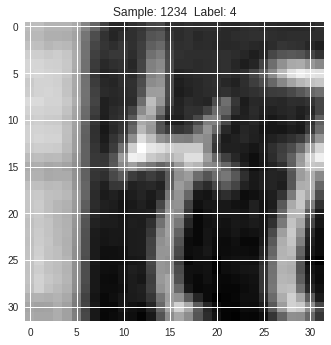

In [0]:
display_sample(1234,X_train_gray)

The input shape is now constructed so that the neural network may accept the processed images.

In [0]:
if K.image_data_format() == 'channels_first':
    X_train_gray = X_train_gray.reshape(X_train_gray.shape[0], 1, 32, 32)
    X_val_gray = X_val_gray.reshape(X_val_gray.shape[0], 1, 32, 32)
    X_test = X_test.reshape(X_test.shape[0], 1, 32, 32)
    input_shape = (1, 32, 32)
else:
    X_train_gray = X_train_gray.reshape(X_train_gray.shape[0], 32, 32, 1)
    X_test_gray = X_test_gray.reshape(X_test.shape[0], 32, 32, 1)
    X_val_gray = X_val_gray.reshape(X_val_gray.shape[0], 32, 32, 1)
    input_shape = (32, 32, 1)
    

# Network Architecture Configuration

Using a Squential Model uses:

*   4 CNN  with RELU  activation function and padding
*   Dropout as a regularization method
*   Softmax as  the activation  function of the last layer
*  Adam as the optmizer and as a categorical_crossentropy loss function





In [0]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape) )
                 

# 64 3x3 kernels
model.add(Conv2D(64, (3, 3), activation='relu', padding = 'same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding = 'same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding = 'same'))


# Reduce by taking the max of each 2x2 block
model.add(MaxPooling2D(pool_size=(2, 2)))
# Dropout to avoid overfitting
model.add(Dropout(0.25))
# Flatten the results to one dimension for passing into our final layer
model.add(Flatten())
# A hidden layer to learn with
model.add(Dense(128, activation='relu'))

# Final categorization from 0-9 with softmax
model.add(Dense(10, activation='softmax'))

###################original#############


model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 30, 30, 32)        320       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 30, 30, 64)        18496     
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 30, 30, 64)        36928     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 30, 30, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 14400)             0         
__________

#Model Training

The model is fed with the training data, using a batch size = 100 and  10 epochs.

In [0]:
history = model.fit(X_train_gray, train_labels,
                    batch_size=100,
                    epochs=10,
                    verbose=2,
                    validation_data=(X_val_gray, y_val_labels))

Train on 59337 samples, validate on 6594 samples
Epoch 1/10
 - 972s - loss: 0.9132 - acc: 0.7046 - val_loss: 0.4626 - val_acc: 0.8640
Epoch 2/10
 - 958s - loss: 0.4092 - acc: 0.8799 - val_loss: 0.3601 - val_acc: 0.8958
Epoch 3/10
 - 961s - loss: 0.3190 - acc: 0.9050 - val_loss: 0.3315 - val_acc: 0.9017
Epoch 4/10
 - 961s - loss: 0.2653 - acc: 0.9212 - val_loss: 0.3658 - val_acc: 0.8990
Epoch 5/10
 - 968s - loss: 0.2182 - acc: 0.9338 - val_loss: 0.3599 - val_acc: 0.8995
Epoch 6/10
 - 964s - loss: 0.1869 - acc: 0.9428 - val_loss: 0.3481 - val_acc: 0.9073
Epoch 7/10
 - 966s - loss: 0.1508 - acc: 0.9524 - val_loss: 0.3639 - val_acc: 0.9052
Epoch 8/10
 - 968s - loss: 0.1267 - acc: 0.9599 - val_loss: 0.4063 - val_acc: 0.9001
Epoch 9/10
 - 962s - loss: 0.1109 - acc: 0.9649 - val_loss: 0.4101 - val_acc: 0.9037
Epoch 10/10
 - 953s - loss: 0.1019 - acc: 0.9673 - val_loss: 0.4182 - val_acc: 0.9070


# Model Testing 

In [0]:
score = model.evaluate(X_test_gray, test_labels, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


Test loss: 0.469639831618134
Test accuracy: 0.8971266


Here, we obtain the Prediction for Test data set and display 15 test images with their predication 

5
5
2
2
1
1
0
0
6
6
1
1
9
9
1
1
1
1
8
8
3
7
6
6
5
5
1
1
4
4


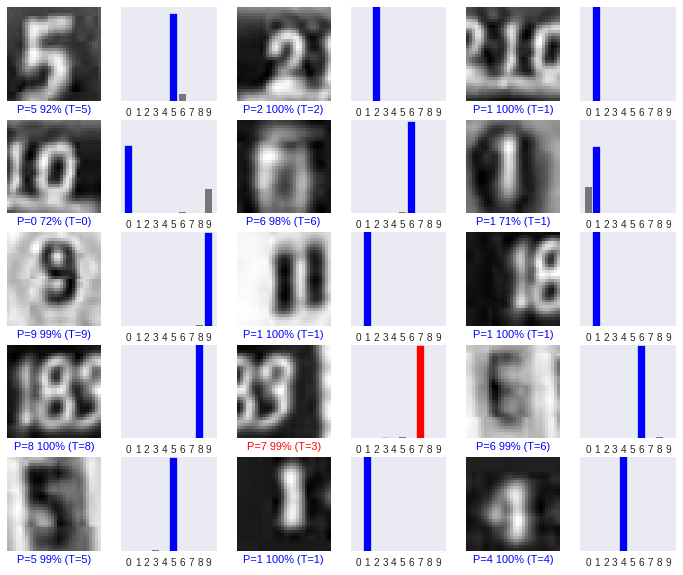

In [0]:
predictions = model.predict(X_test_gray)

num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, test_labels, X_test_gray)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions, test_labels)
  plt.xticks(range(10), class_names)

  
plt.show()


Finally, we save the model for future use.

In [0]:
model.save('drive/My Drive/Colab Notebooks/Model.h5')